In [48]:
import os
import glob
import pandas as pd

from utils import TextPreprocessor

from pprint import pprint
from collections import Counter
from wordcloud import WordCloud

import gensim
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models
import gensim.corpora as corpora

# Path config

In [49]:
data_path = os.path.join(os.getcwd() , 'data')
lda_results_path = os.path.join(os.getcwd() , 'lda_results')

In [3]:
data_path

'/home/uzair/github/news-data-analysis/data'

# Reading csvs

In [4]:
data = [pd.read_csv(csv) for csv in glob.glob(os.path.join(data_path, '*csv'))]

In [5]:
data  = pd.concat(data, axis=0)

In [6]:
data

,title,text,published_date
0,Business Beat: A look back at some of the Long...,Jo Lee Ferguson wishes she kept her maiden nam...,None
1,Oceanside Economic News: 2021 Business Opening...,Business Oceanside Economic News: 2021 Busines...,2022-01-02 00:39:58+00:00
2,US companies are thriving despite the pandemic...,Nearly two years after the coronavirus pandemi...,None
3,16-year-old student athlete starts small business,16-year-old student athlete starts small busin...,2022-01-01 22:09:00+00:00
4,To make your financial New Year's resolutions ...,MilosStankovic | E+ | Getty Images\n\nPeople h...,2022-01-01 00:00:00
...,...,...,...
28276,Just in time for summer: 2 Vancouver beaches c...,With hot weather on the way this weekend for t...,2022-06-24 18:36:00-04:00
28277,Travel therapy: Vacations can benefit people w...,"JOONDALUP, Australia — Ever feel like heading ...",2022-06-24 17:18:02+00:00
28278,"The healthiest communities in America, accordi...","For the third year in a row, Los Alamos County...",2022-06-24 00:00:00
28279,Thinking about buying stock in Blue Hat Intera...,"NEW YORK, June 24, 2022 /PRNewswire/ -- Invest...",None


# Considering only title for analysis

In [7]:
data.drop(['text', 'published_date'], axis=1, inplace=True)

# Text preprocessing

In [8]:
text_prepocessor = TextPreprocessor(
    stopwords=True,
    stemming=False,
    lemmatization=True,
    html_tags=True,
    urls=True,
    punctuation=True,
    digits=True,
    max_word_lenth=3
)

In [9]:
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

In [10]:
data['preocessed'] = data['title'].apply(text_prepocessor.preprocess)

In [11]:
data['preocessed']

0        business beat look back longview best business...
1        oceanside economic news business opening notab...
2                        company thriving despite pandemic
3            year old student athlete start small business
4            make financial new year resolution stick need
                               ...                        
28262                                     courage campaign
28263                      city record covid related death
28268                         need new abortion law canada
28276    time summer vancouver beach closed swimming du...
28279    thinking buying stock blue hat interactive vro...
Name: preocessed, Length: 78625, dtype: object

# Analysing data

In [42]:
data_wrods = data['preocessed'].str.split()
all_text_tokens = " ".join(data['preocessed']).split()

In [33]:
word_freq = Counter(all_text_tokens).most_common(25)
word_freq_df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])
word_freq_df

,Word,Frequency
0,health,6437
1,new,5698
2,news,5670
3,covid,3977
4,world,3599
5,nation,3479
6,business,3237
7,say,3192
8,technology,2997
9,sport,2577


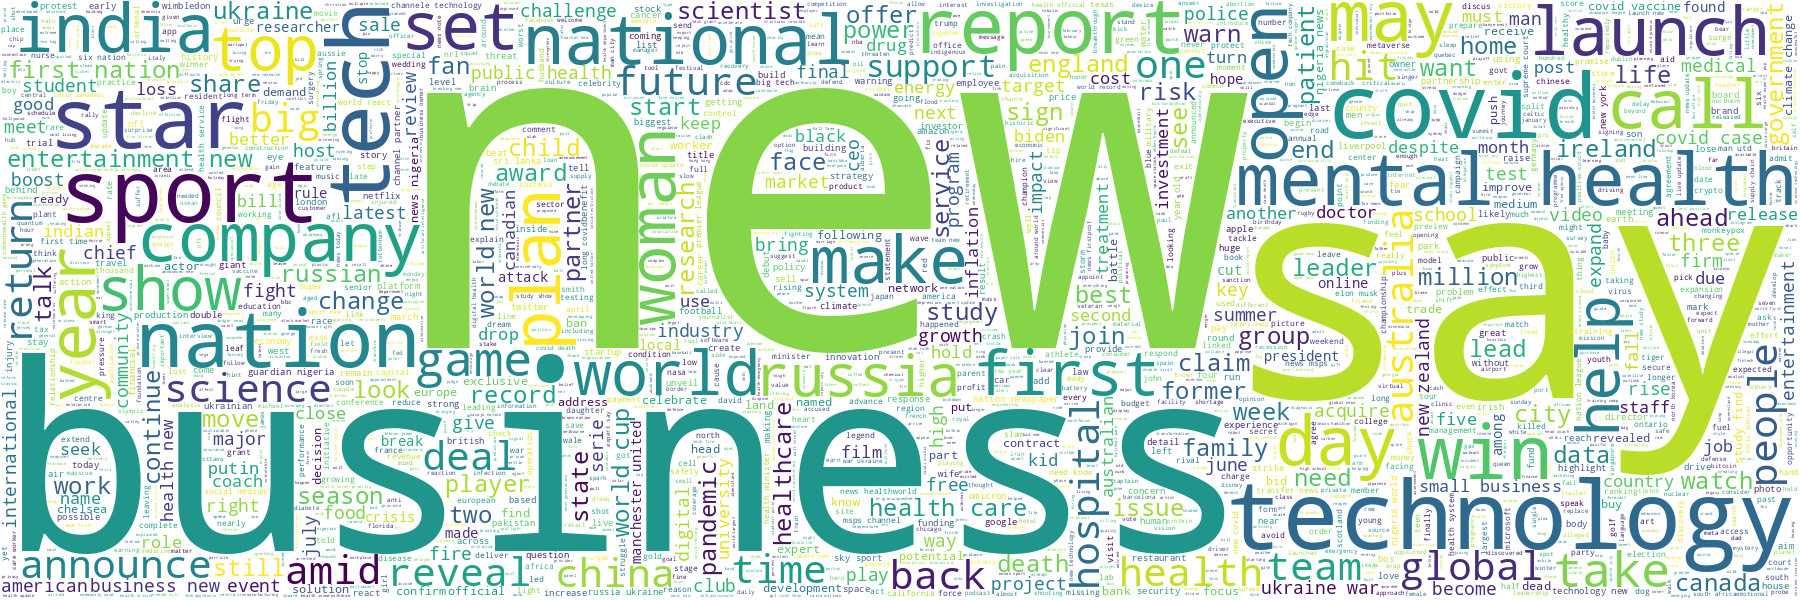

In [34]:
long_string = ','.join(all_text_tokens)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='steelblue', height=600, width=1800)
wordcloud.generate(long_string)
wordcloud.to_image()

# Latent Dirichlet Allocation (LDA) - Topic Modeling

In [44]:
id2word = corpora.Dictionary(data_wrods)
corpus = [id2word.doc2bow(text) for text in data_wrods]
data_wrods[:1][0][:30], corpus[:1][0][:30]

(['business', 'beat', 'look', 'back', 'longview', 'best', 'business', 'news'],
 [(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1)])

In [46]:
num_topics = 10
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.028*"business" + 0.018*"news" + 0.016*"tech" + 0.006*"technology" + '
  '0.006*"say" + 0.006*"new" + 0.006*"stock" + 0.006*"partner" + 0.005*"big" + '
  '0.005*"india"'),
 (1,
  '0.028*"health" + 0.015*"new" + 0.009*"change" + 0.006*"mental" + '
  '0.006*"first" + 0.005*"news" + 0.005*"climate" + 0.005*"say" + '
  '0.004*"sport" + 0.004*"world"'),
 (2,
  '0.017*"sport" + 0.014*"news" + 0.012*"nation" + 0.010*"world" + 0.008*"cup" '
  '+ 0.007*"team" + 0.006*"new" + 0.006*"july" + 0.006*"final" + 0.005*"star"'),
 (3,
  '0.014*"ukraine" + 0.011*"world" + 0.010*"news" + 0.009*"national" + '
  '0.009*"russia" + 0.008*"war" + 0.007*"nation" + 0.006*"sport" + '
  '0.006*"june" + 0.005*"first"'),
 (4,
  '0.012*"covid" + 0.007*"year" + 0.006*"nation" + 0.006*"business" + '
  '0.006*"million" + 0.005*"national" + 0.005*"first" + 0.005*"centre" + '
  '0.004*"say" + 0.004*"announces"'),
 (5,
  '0.020*"world" + 0.016*"news" + 0.008*"nigeria" + 0.007*"nation" + '
  '0.007*"health" + 0.007

In [51]:
pyLDAvis.enable_notebook()
lda_data_file_path = os.path.join(lda_results_path, 'lda_'+str(num_topics))

lda_visualization = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
with open(lda_data_file_path, 'wb') as f:
    pickle.dump(lda_visualization, f)

with open(lda_data_file_path, 'rb') as f:
    lda_visualization = pickle.load(f)
    
pyLDAvis.save_html(lda_visualization, os.path.join(lda_results_path, 'lda_visualization_'+ str(num_topics) +'.html'))
lda_visualization

/home/uzair/miniconda3/envs/news-analysis/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.088240 -0.035900       1        1  12.263931
2     -0.126574 -0.043466       2        1  11.432592
3     -0.093343 -0.022850       3        1  10.710400
8      0.087470 -0.029275       4        1  10.473972
0      0.067648 -0.103346       5        1  10.071812
1      0.038046 -0.017506       6        1   9.722180
5     -0.096998 -0.065423       7        1   9.632445
6      0.040883  0.118935       8        1   8.656201
9     -0.062041  0.140887       9        1   8.549899
4      0.056669  0.057944      10        1   8.486568, topic_info=             Term         Freq        Total Category  logprob  loglift
377        health  6834.000000  6834.000000  Default  30.0000  30.0000
66          covid  4458.000000  4458.000000  Default  29.0000  29.0000
3        business  3372.000000  3372.000000  Default  28.0000  28.0000
451    technology  2901.000000  2901.000000  Default  27.0000  27.0000
25            new  5972.000000  5972.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
604          plan   115.400065   959.790263  Topic10  -6.1489   0.3484
11851        june   111.929354   650.491120  Topic10  -6.1794   0.7068
377        health   114.822341  6834.152125  Topic10  -6.1539  -1.6196
451    technology   112.554591  2901.860235  Topic10  -6.1738  -0.7830
526       reveals   108.168988   657.814835  Topic10  -6.2136   0.6615

[870 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
13737      1  0.934845       aamir
13737     10  0.051936       aamir
10689     10  0.972239    abhishek
9534       2  0.974021  aboriginal
9211       1  0.016118    abortion
...      ...       ...         ...
2131       3  0.004235     zealand
2131       4  0.692411     zealand
2131       6  0.207511     zealand
2131       7  0.006352     zealand
2131       9  0.006352     zealand

[3172 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 4, 9, 1, 2, 6, 7, 10, 5])